In [24]:
import io
import math
import os
import requests
import zipfile

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from collections import defaultdict
from contextlib import closing

from sklearn.neighbors import KNeighborsClassifier # conda install scikit-learn
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from ucimlrepo import fetch_ucirepo # !pip3 install --user git+https://github.com/uci-ml-repo/ucimlrepo.git

%matplotlib inline

In [2]:
# fetch dataset 
dry_bean_dataset = fetch_ucirepo(id=602) 

{'uci_id': 602, 'name': 'Dry Bean Dataset', 'repository_url': 'https://archive.ics.uci.edu/dataset/602/dry+bean+dataset', 'data_url': 'https://archive.ics.uci.edu/static/public/602/data.csv', 'abstract': 'Images of 13,611 grains of 7 different registered dry beans were taken with a high-resolution camera. A total of 16 features; 12 dimensions and 4 shape forms, were obtained from the grains.', 'area': 'Computer Science', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 13611, 'num_features': 16, 'feature_types': ['Integer', 'Real'], 'demographics': [], 'target_col': ['Class'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 2020, 'last_updated': 'Thu Aug 10 2023', 'dataset_doi': '10.24432/C50S4B', 'creators': [], 'intro_paper': {'title': 'Multiclass classification of dry beans using computer vision and machine learning techniques', 'authors': 'M. Koklu, Ilker Ali Özkan', 'published_in': 'Compute

In [8]:
  
# data (as pandas dataframes) 
X = dry_bean_dataset.data.features 
y = dry_bean_dataset.data.targets 

# metadata 
print(dry_bean_dataset.metadata['abstract']) 
print(f"\nDOI: {dry_bean_dataset.metadata['intro_paper']['doi']}\n") 
  
# variable information 
print(dry_bean_dataset.variables) 

Images of 13,611 grains of 7 different registered dry beans were taken with a high-resolution camera. A total of 16 features; 12 dimensions and 4 shape forms, were obtained from the grains.

DOI: 10.1016/j.compag.2020.105507

               name     role         type demographic  \
0              Area  Feature      Integer        None   
1         Perimeter  Feature   Continuous        None   
2   MajorAxisLength  Feature   Continuous        None   
3   MinorAxisLength  Feature   Continuous        None   
4       AspectRatio  Feature   Continuous        None   
5      Eccentricity  Feature   Continuous        None   
6        ConvexArea  Feature      Integer        None   
7     EquivDiameter  Feature   Continuous        None   
8            Extent  Feature   Continuous        None   
9          Solidity  Feature   Continuous        None   
10        Roundness  Feature   Continuous        None   
11      Compactness  Feature   Continuous        None   
12     ShapeFactor1  Feature   Co

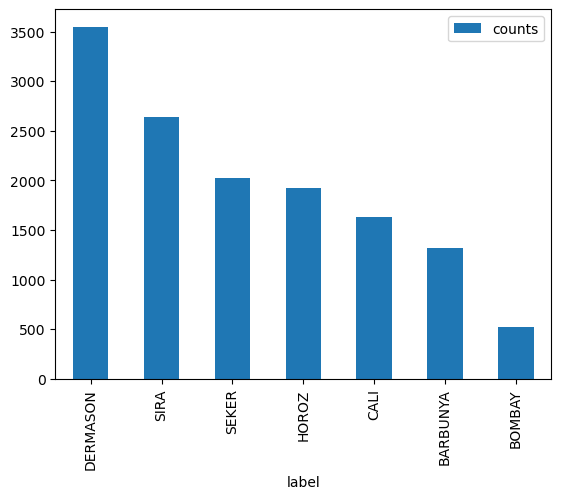

In [9]:
unique, counts = np.unique(y,return_counts=True)
ucdata = sorted(list(zip(unique,counts)),key=lambda x: x[1],reverse=True)
total = sum(counts)

hdata = pd.DataFrame(ucdata,columns=['label','counts'])
hdata.set_index('label',inplace=True)
hdata.plot(kind='bar')
plt.show()

<Axes: >

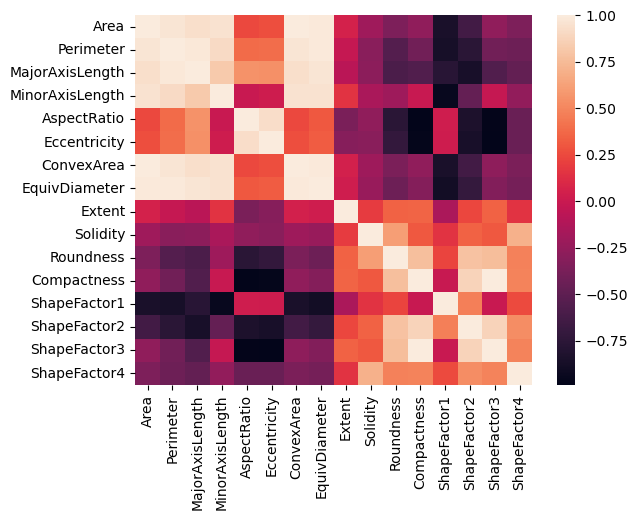

In [10]:
Xcorr = X.corr()
sns.heatmap(Xcorr)

/home/craig/anaconda3/envs/dtsa-5509/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


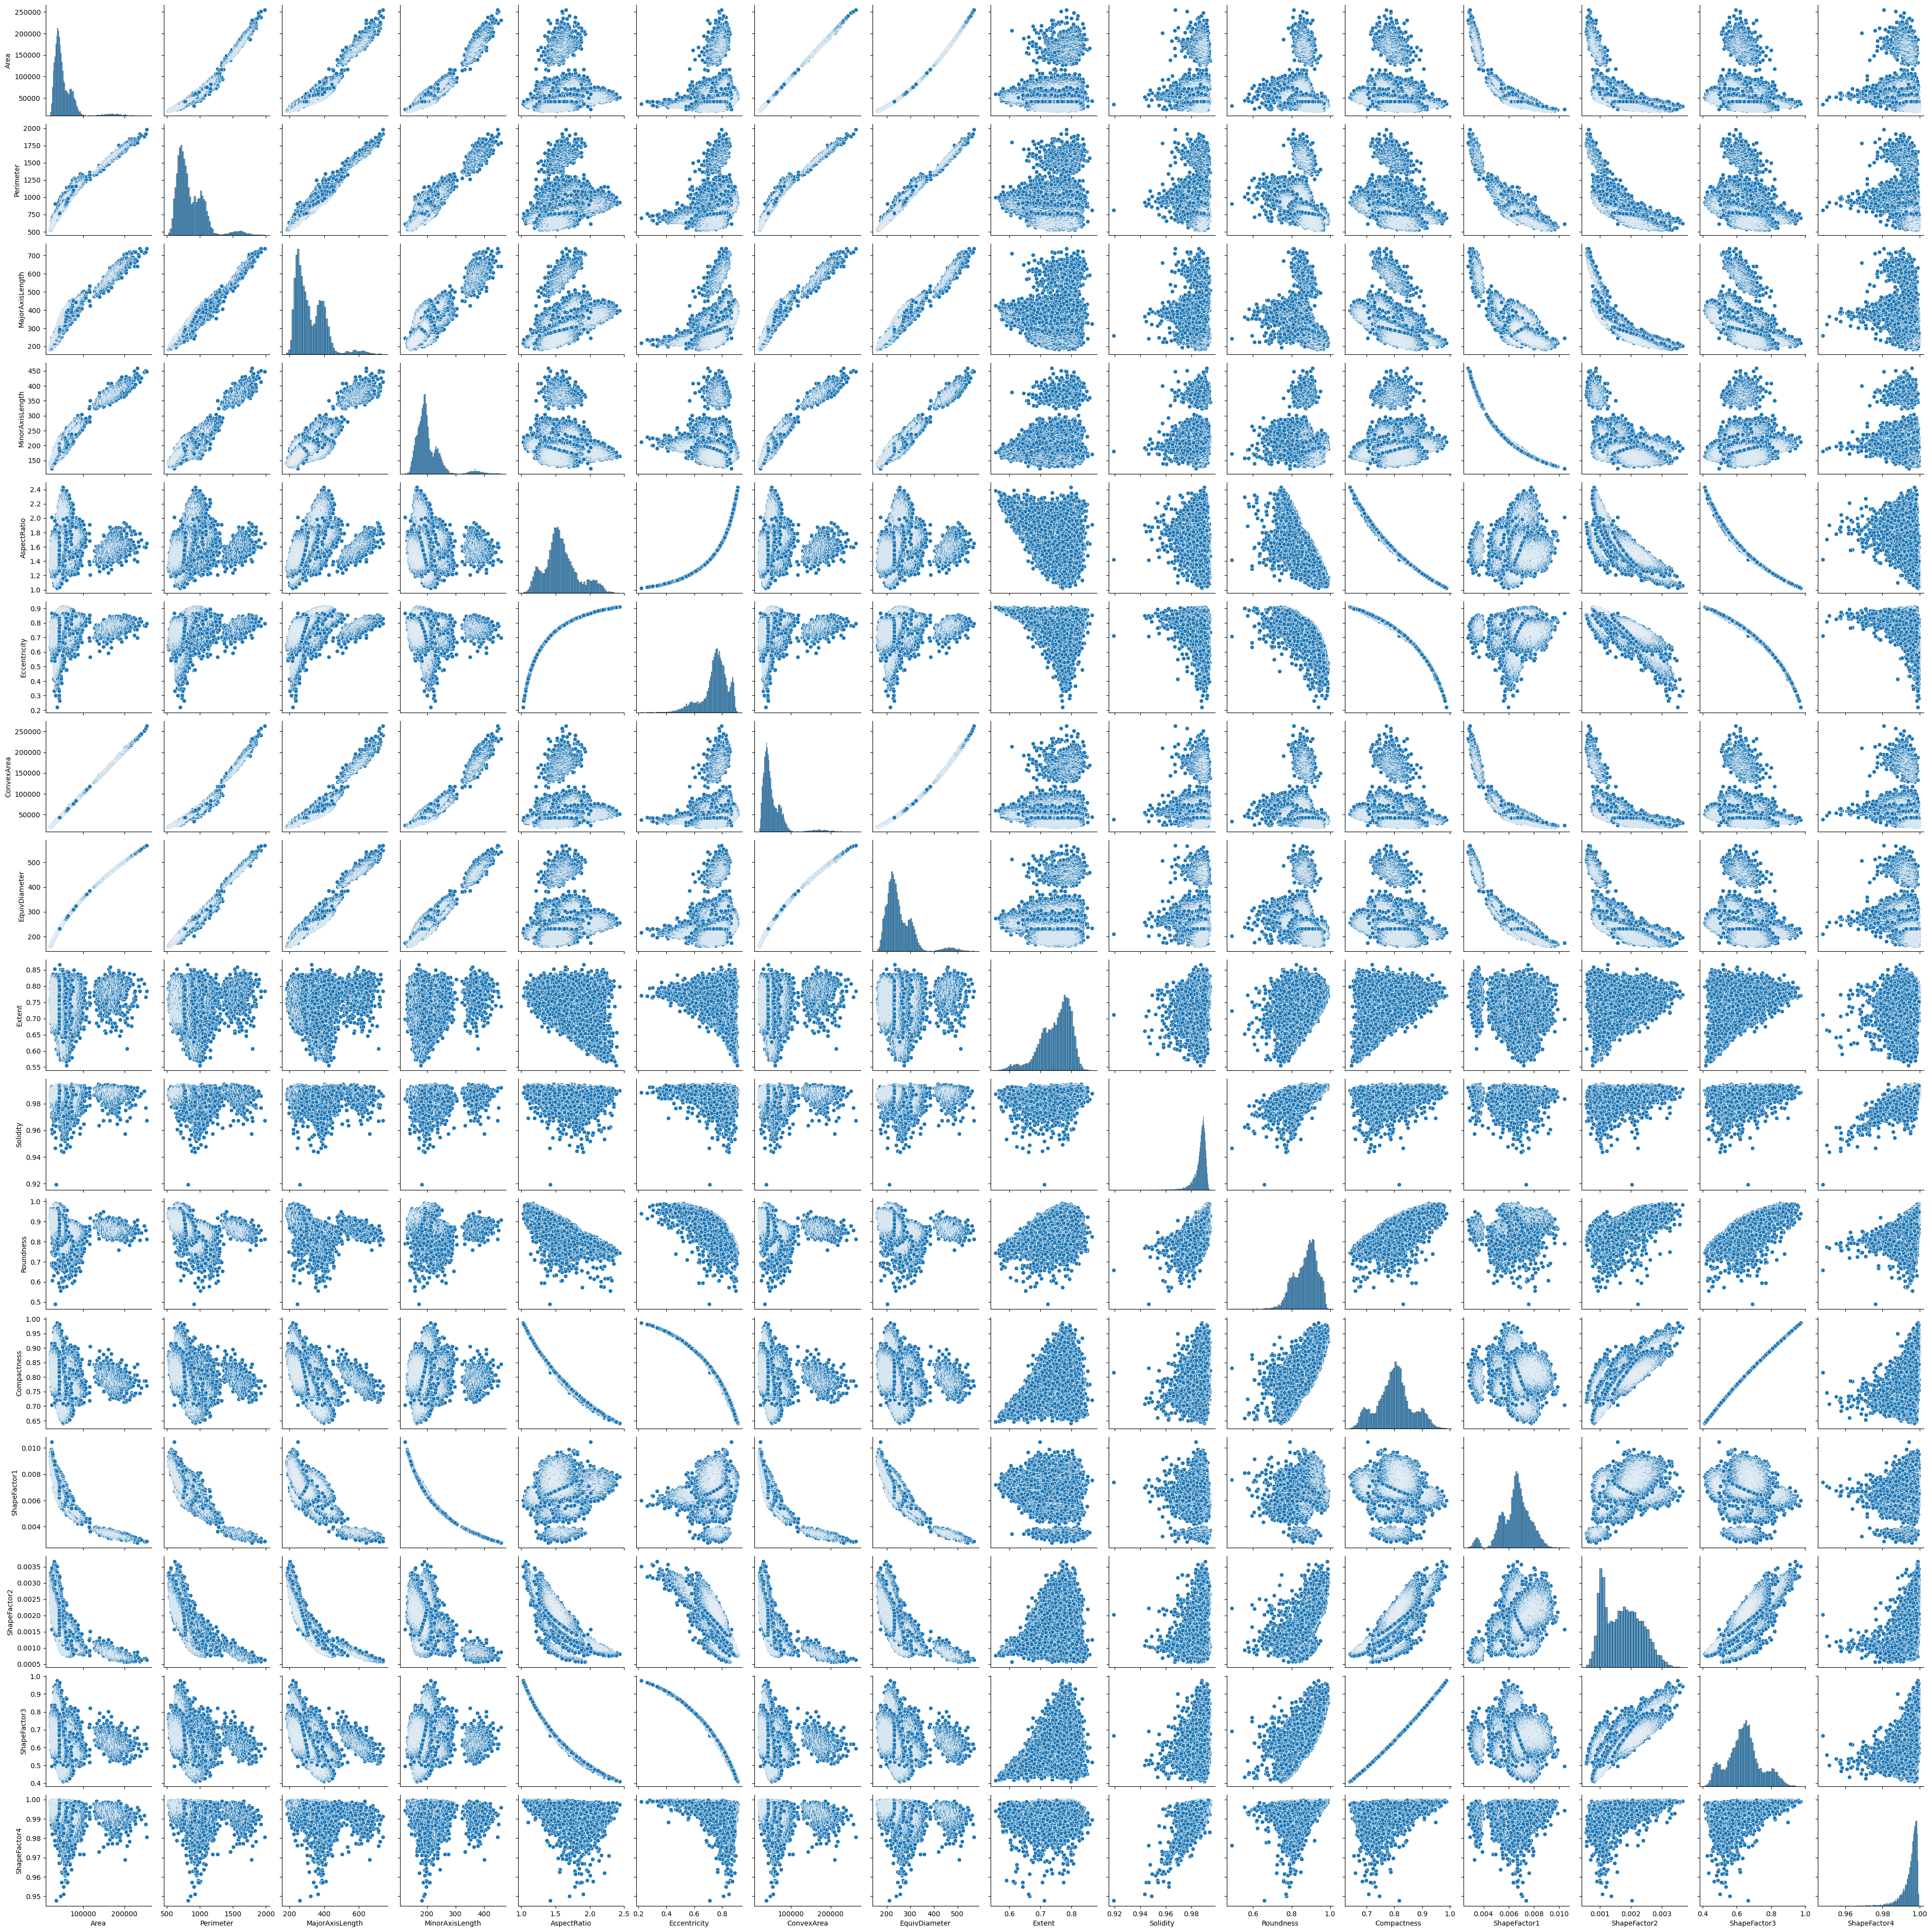

In [11]:
sns.pairplot(X)

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)

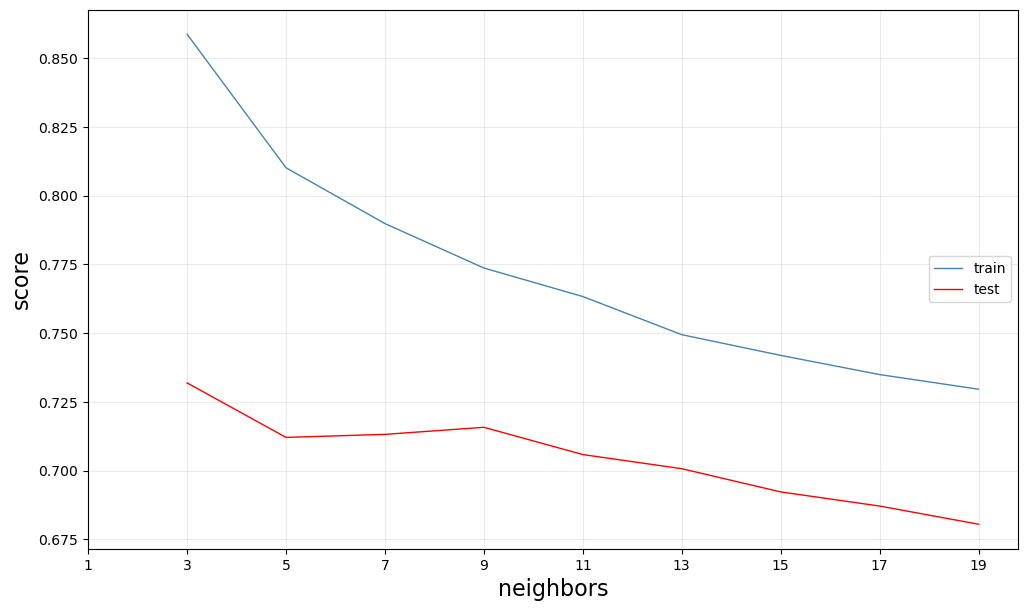

In [56]:
clfs = list()
for k in range(3,21,2):
    clf = KNeighborsClassifier(n_neighbors=k).fit(X_train,y_train.values.ravel())
    train_score = clf.score(X_train,y_train.values.ravel())
    test_score = clf.score(X_test,y_test.values.ravel())
    clfs.append((k,clf,train_score,test_score))

ks = [knn[0] for knn in clfs]
train_scores = [knn[2] for knn in clfs]
test_scores = [knn[3] for knn in clfs]
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(12,7))
ax.plot(ks, train_scores, color="steelblue", lw=1, label="train")
ax.plot(ks, test_scores, color="red", lw=1, label="test")
ax.set_xlabel("neighbors", fontsize=16)
ax.set_ylabel("score", fontsize=16)
plt.xticks(range(1,len(ds)+1,2))
ax.legend(loc='center right')
ax.grid(alpha=0.25)

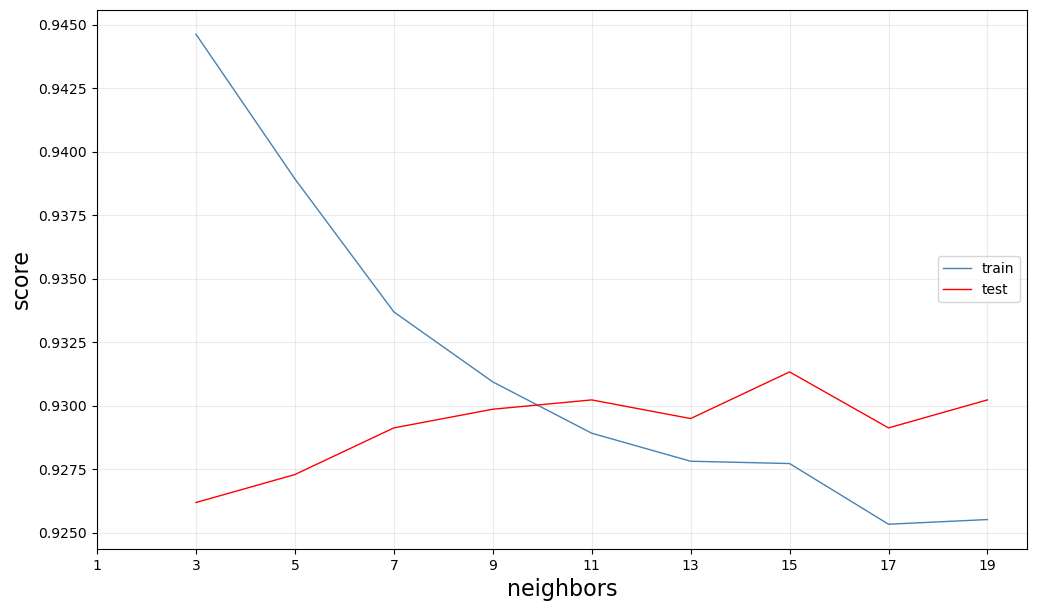

In [57]:
def normalize(col,ucol):
    """
    normalize a column, ucol is the column from all observations (pre-split)
    """
    cmax = max(ucol)
    cmin = min(ucol)
    assert cmax >= max(col)
    assert cmin <= min(col)
    cscale = (cmax - cmin)
    return (col - cmin)/cscale

X_train_norm = X_train.copy()
X_test_norm = X_test.copy()
for col in X.columns:
    X_train_norm[col] = normalize(X_train_norm[col],X[col])
    X_test_norm[col] = normalize(X_test_norm[col],X[col])

nclfs = list()
for k in range(3,21,2):
    nclf = KNeighborsClassifier(n_neighbors=k).fit(X_train_norm,y_train.values.ravel())
    ntrain_score = nclf.score(X_train_norm,y_train.values.ravel())
    ntest_score = nclf.score(X_test_norm,y_test.values.ravel())
    nclfs.append((k,nclf,ntrain_score,ntest_score))

ks = [knn[0] for knn in nclfs]
ntrain_scores = [knn[2] for knn in nclfs]
ntest_scores = [knn[3] for knn in nclfs]
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(12,7))
ax.plot(ks, ntrain_scores, color="steelblue", lw=1, label="train")
ax.plot(ks, ntest_scores, color="red", lw=1, label="test")
ax.set_xlabel("neighbors", fontsize=16)
ax.set_ylabel("score", fontsize=16)
plt.xticks(range(1,len(ds)+1,2))
ax.legend(loc='center right')
ax.grid(alpha=0.25)

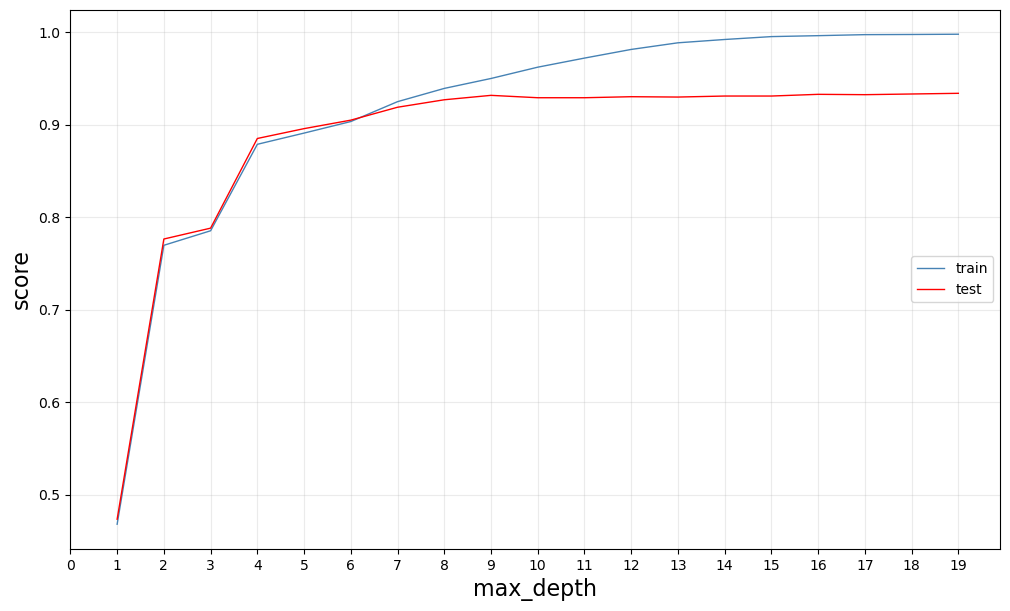

In [38]:
rfclfs = list()
for d in range(1,20):
    rfclf = RandomForestClassifier(max_depth=d).fit(X_train,y_train.values.ravel())
    train_score = rfclf.score(X_train,y_train.values.ravel())
    test_score = rfclf.score(X_test,y_test.values.ravel())
    rfclfs.append((d,rfclf,train_score,test_score))

ds = [rf[0] for rf in rfclfs]
train_scores = [rf[2] for rf in rfclfs]
test_scores = [rf[3] for rf in rfclfs]
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(12,7))
ax.plot(ds, train_scores, color="steelblue", lw=1, label="train")
ax.plot(ds, test_scores, color="red", lw=1, label="test")
ax.set_xlabel("max_depth", fontsize=16)
ax.set_ylabel("score", fontsize=16)
plt.xticks(range(0,len(ds)+1,1))
ax.legend(loc='center right')
ax.grid(alpha=0.25)